# Dataprocessing the Pecan dataset using pandas

### Importing libraries

In [114]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime
plt.style.use('ggplot')
import matplotlib.dates as dates

# plots directory
figure_directory= 'Discriminative-Sparse-Coding-for-Energy-Disaggregation/figures/'
# change so that all figures have font size defulat as 22
plt.rcParams.update({'font.size': 18})
# figure size always the same
plt.figure(figsize=(16,12))

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

In [4]:
import os
import sys
import pandas as pd
from collections import defaultdict

In [217]:
def read_data():
    
    houses = [135, 275, 580, 898]
    df = pd.DataFrame()
    for house in houses:
        house_df = pd.read_csv('datasets/{}.csv'.format(str(house)))
        house_df['DateTime'] = pd.to_datetime(house_df['DateTime'])
        house_df = house_df.set_index('DateTime')
        house_df = house_df.resample('1H').first()  # resample from 15 mins to 1 hour 
        house_df = house_df.reset_index(drop=False) 
        print(len(house_df))
               
        house_df.columns = ['localhour', 'use', 'air1', 'furnace1', 'dishwasher1', 'regrigerator1']  
        appliances_sum = house_df[['air1', 'furnace1', 'dishwasher1', 'regrigerator1']].sum(axis=1)
        house_df['other'] = house_df['use'].subtract(appliances_sum)
        house_df['house'] = house
        house_df = house_df.set_index('house')
        df = pd.concat([df, house_df])
                               
    return df

df = read_data()
df.head()

8759
8759
8759
8759


,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,
135,2014-01-01 01:00:00,0.158,0.000,0.009,0.0,0.0,0.149
135,2014-01-01 02:00:00,1.097,0.759,0.060,0.0,0.0,0.278
135,2014-01-01 03:00:00,0.715,0.522,0.045,0.0,0.0,0.148
135,2014-01-01 04:00:00,0.111,0.000,0.009,0.0,0.0,0.102
135,2014-01-01 05:00:00,0.712,0.555,0.043,0.0,0.0,0.114


In [181]:
df.describe()

,use,air1,furnace1,dishwasher1,regrigerator1,other
count,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000,35032.000000
mean,0.643213,0.210109,0.087802,0.005515,0.053859,0.285929
std,0.785328,0.511516,0.290864,0.054339,0.058323,0.332453
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.055000
25%,0.151000,0.000000,0.007000,0.000000,0.000000,0.064000
50%,0.321000,0.000000,0.011000,0.000000,0.040000,0.192000
75%,0.836000,0.002000,0.051000,0.000000,0.090000,0.375000
max,7.447000,3.468000,5.165000,1.125000,0.750000,4.802000


In [190]:
def format_data(df):
    '''
    Parameters: df dataframe of the apppliacnes
    Return: X^T x m
    '''
    d = {}
    houses = [135, 275, 580,  898]
    for appliance in df.columns.tolist():
        started = 0
        for i in houses:

            if started == 0:

                d[str(appliance)] = df[[str(appliance)]][df[str(appliance)].index == i]
                started = 1
                dfindex = d[str(appliance)].index
            else:

                d[str(appliance)][str(i)] = pd.Series(df[str(appliance)][df[str(appliance)].index == i].values,index=dfindex)

        d[str(appliance)]=d[str(appliance)].rename(columns = {str(appliance):str(dfindex[0])})
        d[str(appliance)].reset_index(drop=True, inplace=True)
    return d
    
dic = format_data(df)
dic['use'].head(5)

,135,275,580,898
0,0.158,1.414,0.102,0.488
1,1.097,1.090,0.101,0.531
2,0.715,0.976,0.101,0.222
3,0.111,1.004,5.169,0.222
4,0.712,0.826,2.633,0.193


In [281]:
key = list(dic.keys())
key
# columns = dic[key].columns.tolist()

['localtime',
 'use',
 'air1',
 'furnace1',
 'dishwasher1',
 'regrigerator1',
 'other']

In [209]:
def split(d,portion,timeframe, portion_houses=None, option=None):
    '''
    Parameters: d = dictionary, portion 0.5 - 0.9, timeframe 1-8760

    Return: x_train,x_test dictionarys containing dataframes of all the appliances within the timeframe.
    '''

    x_train = {}
    x_test = {}
    timeframe = range(timeframe)
    columns = list(dic.keys())
    train_list  = timeframe[int(len(timeframe) * 0.0):int(len(timeframe) * portion)]
    test_list = timeframe[int(len(timeframe) * portion):int(len(timeframe) * 1.0)]
    '''
    start_day_2014 = 3 # thursday
    if option == 'week':
        for key in d.keys():
            x_train[key] = d[key].loc
    '''
    if portion_houses != None:
        houses  = columns[int(len(columns) * 0.0): int(len(columns) * portion_houses)]

    for key in d.keys():

        if portion_houses != None:
            x_train[key] = d[key].loc[train_list,houses]
            x_test[key] = d[key].loc[test_list,houses]
        else:
            x_train[key] = d[key].loc[train_list,:]
            x_test[key] = d[key].loc[test_list,:]

    return x_train,x_test

In [215]:
x_train,x_test = split(dic, 0.5, 12)
x_test

{'localtime':                    135                 275                 580  \
 6  2014-01-01 07:00:00 2014-01-01 07:00:00 2014-01-01 07:00:00   
 7  2014-01-01 08:00:00 2014-01-01 08:00:00 2014-01-01 08:00:00   
 8  2014-01-01 09:00:00 2014-01-01 09:00:00 2014-01-01 09:00:00   
 9  2014-01-01 10:00:00 2014-01-01 10:00:00 2014-01-01 10:00:00   
 10 2014-01-01 11:00:00 2014-01-01 11:00:00 2014-01-01 11:00:00   
 11 2014-01-01 12:00:00 2014-01-01 12:00:00 2014-01-01 12:00:00   
 
                    898  
 6  2014-01-01 07:00:00  
 7  2014-01-01 08:00:00  
 8  2014-01-01 09:00:00  
 9  2014-01-01 10:00:00  
 10 2014-01-01 11:00:00  
 11 2014-01-01 12:00:00  , 'use':       135    275    580    898
 6   0.139  0.903  1.095  0.051
 7   1.083  0.997  0.103  0.220
 8   0.104  0.918  1.290  0.250
 9   1.184  0.726  0.112  0.089
 10  0.229  0.513  0.152  0.640
 11  0.225  0.615  3.283  2.059, 'air1':       135  275    580    898
 6   0.000  0.0  0.004  0.000
 7   0.913  0.0  0.000  0.001
 8   

### Data Exploration

In [218]:
local = df['localhour'].tolist()
import datetime, re
xticks = map(lambda x: re.split('\s',x)[0],local)

### Usage for texas is like a poisson distribution, could be used in future research

C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


0.5304968982664318 1.4105031017335665


C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in power


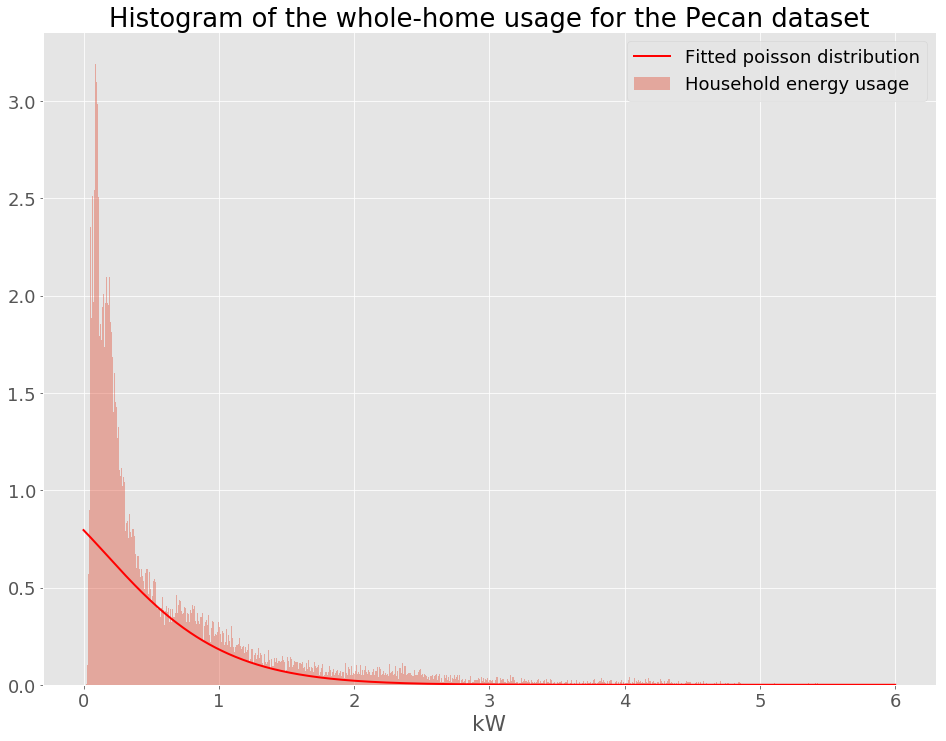

In [282]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy import stats
plt.figure(figsize=(16,12))

#df_plot = np.where(df['use'].values < 6)
df_plot = df['use'].values[np.where(df['use'].values < 6)]
#entries, bin_edges, patches = df_plot[df_plot < 6].hist(bins=1000, figsize=(16,12),normed=True)
# get poisson deviated random numbers
data = np.random.poisson(2, 1000)
entries, bin_edges, patches = plt.hist(df_plot,bins=1000,normed=True,label='Household energy usage', alpha=0.4)

# the bins should be of integer width, because poisson is an integer distribution
#entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

(loc, scale) = stats.exponweib.fit_loc_scale(data, 1, 1)
print(loc, scale)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 6, 1000)

# plt.plot(x, weib(x, loc, scale))
# plt.hist(data, data.max(), normed=True)
curve = plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2,label='Fitted poisson distribution')

plt.title('Histogram of the whole-home usage for the Pecan dataset')
plt.xlabel('kW')
plt.legend()

# plt.savefig(figure_directory+'histusage.png')

C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


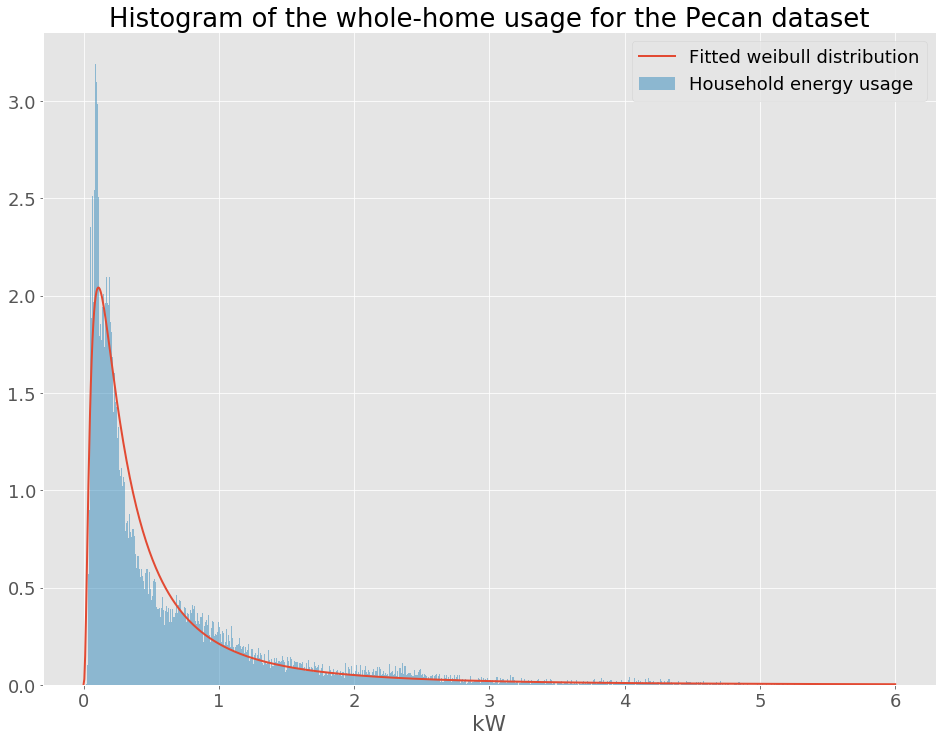

In [235]:
from scipy import stats
plt.figure(figsize=(16,12))
x_plot = np.linspace(0, 6, 1000)
#df_plot = np.where(df['use'].values < 6)
df_plot = df['use'].values[np.where(df['use'].values < 6)]
plt.plot(x_plot, stats.exponweib.pdf(x_plot, *stats.exponweib.fit(df_plot, 1, 1, scale=0.2, loc=0)),lw=2,label='Fitted weibull distribution')
_ = plt.hist(df_plot, bins=1000, normed=True, alpha=0.5, label='Household energy usage');

plt.title('Histogram of the whole-home usage for the Pecan dataset')
plt.xlabel('kW')
plt.legend()

# plt.savefig(figure_directory+'new_histusage.png')

Text(0, 0.5, 'kW')

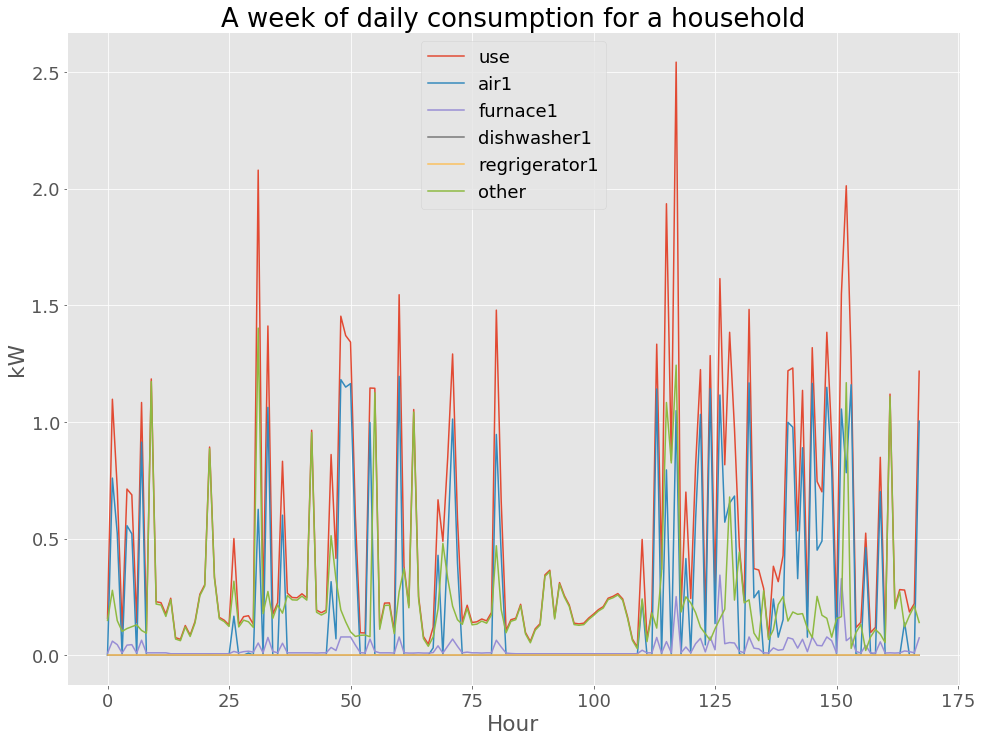

In [238]:
df_test = df.copy()
df_test.drop('localhour', axis=1, inplace=True)
hours = 24*7
df_test[0:hours].reset_index(drop=True).plot(figsize=(16,12))
plt.title('A week of daily consumption for a household')
plt.xlabel('Hour')
plt.ylabel('kW')

In [279]:
df_sort =df.set_index(df['localhour']).sort_index(by='localhour')
average_use = map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique())
# leng = len(average_use)
#
# mean = np.mean(list(average_use))

C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


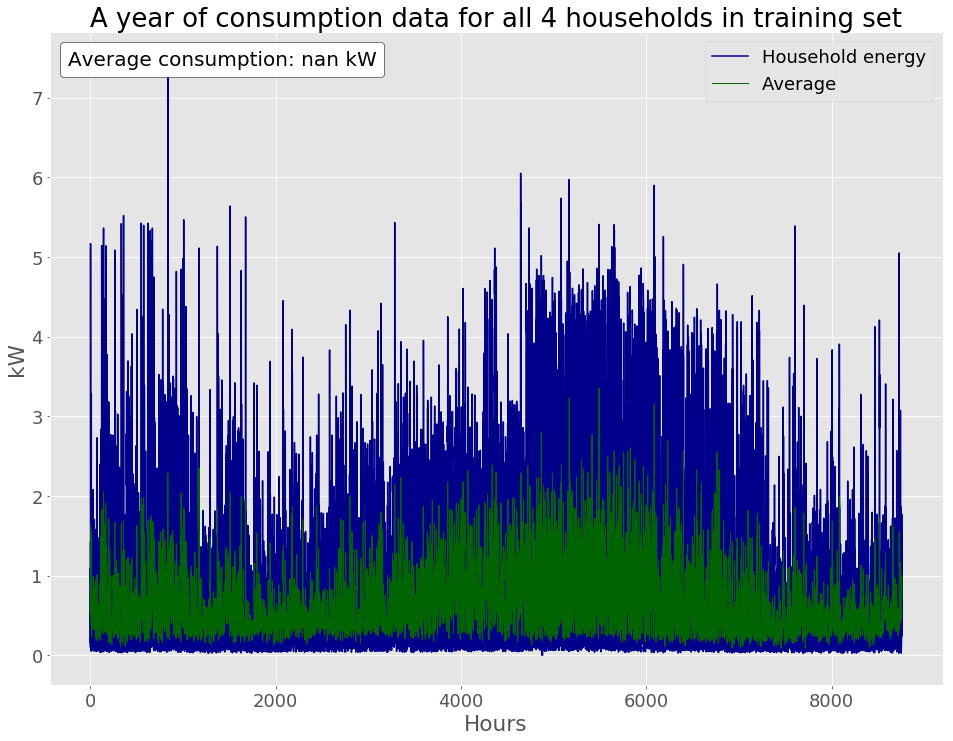

In [280]:
fig, ax = plt.subplots(figsize=(16,12))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', label='Household energy' if i == 0 else '', ax=ax)
    i += 1

s = pd.Series(average_use)
# mean = round(np.mean(list(average_use),3))
s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='DarkGreen',label='Average Use',lw=1, ax=ax)

plt.title('A year of consumption data for all 4 households in training set')
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: " + str(mean) + " kW",
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)